# BiSeNet 구현  
- pytorch로 구현

In [1]:
import os
import time
import random
import warnings
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
from PIL import Image
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
import torchvision.datasets as dsets
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau, StepLR, MultiStepLR, CyclicLR
from torchsummary import summary

from pytorchtools import EarlyStopping, Metrics, CheckPoint, DiceLoss

In [2]:
warnings.filterwarnings('ignore')
%matplotlib inline
plt.rcParams['figure.figsize'] = [10,7]

# Load Data

In [3]:
data = pd.read_csv('./camvid/11_class_dict.csv', index_col=0)

rgb_data = {name:list(data.loc[name, :]) for name in data.index}
rgb_array = {idx:np.array(rgb) for idx, (_, rgb) in enumerate(rgb_data.items())}

data

,r,g,b
name,,,
Sky,128,128,128
Building,128,0,0
Pole,192,192,128
Road,128,64,128
Sidewalk,0,0,192
Tree,128,128,0
SignSymbol,192,128,128
Fence,64,64,128
Car,64,0,128


In [4]:
width = 224
height = 224
num_classes = len(data) # 12 classes (11 object classes and 1 background)

# cuda setting
device = torch.device('cuda')
print(device)

cuda


In [5]:
def load_image(path, subset='train'):
    image_list, label_list = [], []
    image_files = glob(path+subset+'/'+subset+'_images/*.png')
    label_files = glob(path+subset+'/'+subset+'_labels/*.png')
    for file in tqdm(image_files):
        img = cv2.imread(file)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        image_list.append(img)
    for file in tqdm(label_files):
        img = cv2.imread(file)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        label_list.append(img)
    return np.array(image_list), np.array(label_list)

path = './camvid/'
train_image, train_label = load_image(path, subset='train')
valid_image, valid_label = load_image(path, subset='valid')
test_image, test_label = load_image(path, subset='test')

  0%|          | 0/367 [00:00<?, ?it/s]

  0%|          | 0/367 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

  0%|          | 0/233 [00:00<?, ?it/s]

  0%|          | 0/233 [00:00<?, ?it/s]

In [6]:
# image to 12 classes mask
def image2mask(labels):
    semantic_map = []
    for color in tqdm(list(rgb_data.values())):
        equality = np.equal(labels, color)
        class_map = np.all(equality, axis=-1)
        semantic_map.append(class_map)
    semantic_map = np.stack(semantic_map, axis=-1)
    return np.float32(semantic_map)

train_mask = image2mask(train_label)
valid_mask = image2mask(valid_label)
test_mask = image2mask(test_label)

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

In [7]:
# custom data set
class CamVidDataset(Dataset):
    def __init__(self, transforms_, subset='train'):
        self.transforms = transforms.Compose(transforms_)
        if subset=='train':
            self.images = train_image
            self.labels = train_mask
        elif subset=='valid':
            self.images = valid_image
            self.labels = valid_mask
        else:
            self.images = test_image
            self.labels = test_mask
            
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        images = self.images[idx]
        labels = self.labels[idx]
        return self.transforms(images), self.transforms(labels)

In [8]:
batch_size = 16

transforms_ = [
    transforms.ToTensor(),
]

train_loader = DataLoader(
    CamVidDataset(transforms_=transforms_, subset='train'),
    batch_size=batch_size,
    shuffle=True,
    drop_last=True,
)

valid_loader = DataLoader(
    CamVidDataset(transforms_=transforms_, subset='valid'),
    batch_size=len(valid_image),
    shuffle=True,
    drop_last=True,
)

## Build Model

In [9]:
# Conv + Batch Normalization + ReLU
class ConvBlock(nn.Module):
    def __init__(self, in_dim, out_dim, kernel_size=3, stride=2, padding=1):
        super(ConvBlock, self).__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_dim, out_dim, kernel_size=kernel_size, stride=stride, padding=padding),
            nn.BatchNorm2d(out_dim),
            nn.ReLU(),
        )
        
    def forward(self, inputs):
        return self.block(inputs)

In [10]:
# Define Spatial Path
class SpatialPath(nn.Module):
    # input size of image is batch size x 3 x width x height
    # and default value of filter is 64
    def __init__(self, in_dim=3, num_filters=64):
        # Spatial Path has layers of 3 ConvBlock 
        super(SpatialPath, self).__init__()
        # input channel: 3
        self.convblock1 = ConvBlock(in_dim, num_filters)
        # output channel: 64, size: 1/2
        self.convblock2 = ConvBlock(num_filters, num_filters*2)
        # output channel: 128, size: 1/4
        self.convblock3 = ConvBlock(num_filters*2, num_filters*4)
        # output channel: 256, size: 1/8
        
    def forward(self, inputs):
        x = self.convblock1(inputs)
        x = self.convblock2(x)
        x = self.convblock3(x)
        return x

In [11]:
# Define Context Path
class ContextPath(nn.Module):
    def __init__(self, pretrained_model='resnet18'):
        super(ContextPath, self).__init__()
        
        # load pre-trained model called lightweight model in context path
        if pretrained_model=='resnet18':
            features = models.resnet18(pretrained=True)
        elif pretrained_model=='resnet101':
            features = models.resnet101(pretrained=True)
        else:
            print('Please select a pre-trained model')
            
        # build context path using pre-trained model
        self.conv = features.conv1
        self.bn = features.bn1
        self.relu = features.relu
        self.maxpool = features.maxpool
        # 4x down, size: 1/4
        self.layer1 = features.layer1
        # 8x down, size: 1/8
        self.layer2 = features.layer2
        # 16x down, size: 1/16
        self.layer3 = features.layer3
        # 32x down, size: 1/32
        self.layer4 = features.layer4
        
    def forward(self, inputs):
        x = self.conv(inputs)
        x = self.bn(x)
        x = self.relu(x)
        x = self.maxpool(x)
        layer1 = self.layer1(x)
        layer2 = self.layer2(layer1)
        layer3 = self.layer3(layer2)
        layer4 = self.layer4(layer3)
        # global average pooling operation
        tail = torch.mean(layer4, dim=3, keepdim=True)
        tail = torch.mean(tail, dim=2, keepdim=True)
        # the number of output is 3, these will go through ARM
        return layer3, layer4, tail

In [12]:
# Define Attention Refinement Module
class AttentionRefinementModule(nn.Module):
    def __init__(self, in_dim, out_dim):
        super(AttentionRefinementModule, self).__init__()
        # global average pooling with 1x1 output size
        self.gap = nn.AdaptiveAvgPool2d(output_size=(1,1))
        # 1x1 kernel conv layer
        self.conv = nn.Conv2d(in_dim, out_dim, kernel_size=1)
        self.bn = nn.BatchNorm2d(out_dim)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, inputs):
        x = self.gap(inputs)
        x = self.conv(x)
        x = self.bn(x)
        x = self.sigmoid(x)
        x = torch.mul(inputs, x)
        return x

In [13]:
# Define Feature Fusion Module
class FeatureFusionModule(nn.Module):
    def __init__(self, in_dim, out_dim):
        # this module has two inputs and concatenate inputs
        super(FeatureFusionModule, self).__init__()
        # Conv Block with stride 1
        self.convblock = ConvBlock(in_dim, out_dim, stride=1)
        # global average pooling with 1x1 output size
        self.gap = nn.AdaptiveAvgPool2d(output_size=(1,1))
        # 1x1 kernel conv layer
        self.conv1 = nn.Conv2d(out_dim, out_dim, kernel_size=1)
        self.relu = nn.ReLU()
        # 1x1 kernel conv layer
        self.conv2 = nn.Conv2d(out_dim, out_dim, kernel_size=1)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, input_1, input_2):
        # FFM receives two inputs and concatenate with dimension 1
        x = torch.cat((input_1, input_2), dim=1)
        # keep features for mul
        features = self.convblock(x)
        x = self.gap(features)
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.sigmoid(x)
        # mul operation
        x = torch.mul(features, x)
        # add operation
        x = torch.add(x, features)
        return x

In [14]:
# build BiSeNet
class BiSeNet(nn.Module):
    def __init__(self, num_classes=num_classes):
        super(BiSeNet, self).__init__()
        
        # load Spatial Path
        self.spatial_path = SpatialPath()
        
        # load Context Path
        self.context_path = ContextPath()
        
        # 16x dowm-sampling output of Context Path
        self.attention_refinement_module1 = AttentionRefinementModule(256, 256)
        # 32x down-sampling output of Context Path
        self.attention_refinement_module2 = AttentionRefinementModule(512, 512)
        
        # output size of ARM is batch size x 1024 x width x height 
        self.feature_fusion_module = FeatureFusionModule(1024, num_classes)
        
        # A layer to be applied after FFM
        self.conv = nn.Conv2d(num_classes, num_classes, kernel_size=1)
        
    def forward(self, inputs):
        # Spatial Path
        sx = self.spatial_path(inputs)
        
        # Context Path
        cx1, cx2, cx_tail = self.context_path(inputs)
        cx1 = self.attention_refinement_module1(cx1)
        cx2 = self.attention_refinement_module2(cx2)
        cx2 = torch.mul(cx2, cx_tail)
        
        # up-sampling for combining in FFM
        cx1 = F.interpolate(cx1, size=sx.size()[2:], mode='bilinear')
        cx2 = F.interpolate(cx2, size=sx.size()[2:], mode='bilinear')
        cx = torch.cat((cx1,cx2), dim=1)
        
        # FFM
        ffm_output = self.feature_fusion_module(sx, cx)
        
        # 
        result = F.interpolate(ffm_output, scale_factor=8, mode='bilinear')
        output = self.conv(result)
        return output

In [15]:
model = BiSeNet().to(device)
summary(model, (3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           1,792
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         ConvBlock-4         [-1, 64, 112, 112]               0
            Conv2d-5          [-1, 128, 56, 56]          73,856
       BatchNorm2d-6          [-1, 128, 56, 56]             256
              ReLU-7          [-1, 128, 56, 56]               0
         ConvBlock-8          [-1, 128, 56, 56]               0
            Conv2d-9          [-1, 256, 28, 28]         295,168
      BatchNorm2d-10          [-1, 256, 28, 28]             512
             ReLU-11          [-1, 256, 28, 28]               0
        ConvBlock-12          [-1, 256, 28, 28]               0
      SpatialPath-13          [-1, 256, 28, 28]               0
           Conv2d-14         [-1, 64, 1

# Median Frequency Balancing

In [16]:
# class balance of train data set 
train_class_labels = list(rgb_data.keys())
train_class_count = [2925992, 4164714, 113525, 5769970, 771679, 1666212, 191065, 195738,
                     1040037, 97657, 48378, 607456]
print(train_class_labels)

['Sky', 'Building', 'Pole', 'Road', 'Sidewalk', 'Tree', 'SignSymbol', 'Fence', 'Car', 'Pedestrian', 'Bicyclist', 'unlabelled']


In [17]:
# median frequency balancing
weights = torch.tensor(train_class_count, dtype=torch.float32)
median_weights = weights.median()
median_frequency_balancing = median_weights/weights
print(median_frequency_balancing)

tensor([ 0.2076,  0.1459,  5.3509,  0.1053,  0.7872,  0.3646,  3.1793,  3.1034,
         0.5841,  6.2203, 12.5565,  1.0000])


# Set Loss function, Optimizer, learning rate scheduler and early stopping  

**Loss**  
- base loss: log softmax  
$$loss = \frac{1}{N}\sum_i-\log\left(\frac{e^{p_i}}{\sum_je^{p_j}}\right)$$

In [18]:
lr = 1e-4
es_save_path = './model/es_checkpoint.pt'
cp_save_path = './model/cp_checkpoint.pt'
loss_func = nn.CrossEntropyLoss(weight=median_frequency_balancing).to(device)
# loss_func = DiceLoss().to(device)
optimizer = optim.RAdam(model.parameters(), lr=lr)
lr_scheduler = ReduceLROnPlateau(optimizer, 'min', patience=30, factor=0.5, verbose=True)
metric = Metrics(n_classes=num_classes, dim=1) # mIoU, BF score
checkpoint = CheckPoint(verbose=True, path=cp_save_path)
early_stopping = EarlyStopping(patience=100, verbose=True, path=es_save_path)

In [19]:
def train(model,
          train_data,
          validation_data,
          epochs,
          learning_rate_scheduler=False,
          check_point=False,
          early_stop=False,
          last_epoch_save_path='./model/last_checkpoint.pt'):
    # create empty list to append losses and mious of train, validation
    loss_list, miou_list, bf_list = [], [], []
    val_loss_list, val_miou_list, val_bf_list = [], [], []
    ############################# training #############################
    # train the model
    model.train()
    starting = time.time()
    # start training
    for epoch in tqdm(range(epochs)):
        init_time = time.time()
        # train by batch
        for train_images, train_labels in train_data:
            train_images = train_images.to(device)
            train_labels = train_labels.to(device)
            # initialize the gradient to 0
            optimizer.zero_grad()
            
            output_images = model(train_images)
            loss = loss_func(output_images, train_labels)
            miou = metric.get_miou(output_images, train_labels)
            bf = metric.get_f1_score(output_images, train_labels)
            # update loss and optimizer
            loss.backward()
            optimizer.step()
            
        end_time = time.time()
        loss_list.append(loss.item())
        miou_list.append(miou.item())
        bf_list.append(bf.item())
        # check epoch, loss, miou and time
        print(f'\n[Epoch {epoch+1}/{epochs}]'
              f'  [time: {end_time-init_time:.3f}s]'
              f'  [lr = {optimizer.param_groups[0]["lr"]}]')
        print(f'[train loss: {loss.item():.3f}]'
              f'  [train mIoU: {miou.item():.3f}]'
              f'  [train BF: {bf.item():.3f}]')
        
    ############################# validate #############################
        # validate the model
        with torch.no_grad():
            for val_images, val_labels in validation_data:
                val_images, val_labels = val_images.to(device), val_labels.to(device)
                
                val_outputs = model(val_images)
                val_loss = loss_func(val_outputs, val_labels)
                val_miou = metric.get_miou(val_outputs, val_labels)
                val_bf = metric.get_f1_score(val_outputs, val_labels)
                
                if learning_rate_scheduler: 
                    lr_scheduler.step(val_loss)
                    
            val_loss_list.append(val_loss.item())
            val_miou_list.append(val_miou.item())
            val_bf_list.append(val_bf.item())
            # check loss and miou of validation
            print(f'[valid loss: {val_loss.item():.3f}]'
                  f'   [valid mIoU: {val_miou.item():.3f}]'
                  f'   [valid BF: {val_bf.item():.3f}]')
            
        # save model check point
        if check_point:
            checkpoint(val_loss, model)
            
        # set early stopping
        if early_stop:
            assert check_point==False
            early_stopping(val_loss, model)
            if early_stopping.early_stop:
                print('\n##########################\n'
                      '##### Early Stopping #####\n'
                      '##########################')
                break
                
    # if we not set early stopping, the model save at the end of training
    if early_stop==False and check_point==False:
        torch.save(model.state_dict(), last_epoch_save_path)
        print('Saving model of last epoch')
        
    ending = time.time()
    print(f'\n Total time for training is {ending-starting:.3f}s')
    
    return model, loss_list, miou_list, bf_list, val_loss_list, val_miou_list, val_bf_list

In [20]:
EPOCH = 300

model, train_loss, train_miou, train_bf, valid_loss, valid_miou, valid_bf = train(
    model,
    train_loader,
    validation_data=valid_loader,
    epochs=EPOCH,
    learning_rate_scheduler=True,
    check_point=True,
    early_stop=False,
)

  0%|          | 0/300 [00:00<?, ?it/s]


[Epoch 1/300]  [time: 3.429s]  [lr = 0.0001]
[train loss: 1.201]  [train mIoU: 0.065]  [train BF: 0.163]
[valid loss: 1.691]   [valid mIoU: 0.061]   [valid BF: 0.161]
Validation loss decreased (inf --> 1.691).  Saving model ...

[Epoch 2/300]  [time: 3.029s]  [lr = 0.0001]
[train loss: 0.971]  [train mIoU: 0.158]  [train BF: 0.183]
[valid loss: 1.533]   [valid mIoU: 0.178]   [valid BF: 0.179]
Validation loss decreased (1.691 --> 1.533).  Saving model ...

[Epoch 3/300]  [time: 2.978s]  [lr = 0.0001]
[train loss: 0.845]  [train mIoU: 0.228]  [train BF: 0.190]
[valid loss: 1.398]   [valid mIoU: 0.218]   [valid BF: 0.186]
Validation loss decreased (1.533 --> 1.398).  Saving model ...

[Epoch 4/300]  [time: 2.974s]  [lr = 0.0001]
[train loss: 0.790]  [train mIoU: 0.246]  [train BF: 0.194]
[valid loss: 1.306]   [valid mIoU: 0.240]   [valid BF: 0.188]
Validation loss decreased (1.398 --> 1.306).  Saving model ...

[Epoch 5/300]  [time: 2.981s]  [lr = 0.0001]
[train loss: 0.783]  [train mIoU


[Epoch 40/300]  [time: 2.918s]  [lr = 0.0001]
[train loss: 0.474]  [train mIoU: 0.525]  [train BF: 0.217]
[valid loss: 0.961]   [valid mIoU: 0.435]   [valid BF: 0.209]

[Epoch 41/300]  [time: 2.978s]  [lr = 0.0001]
[train loss: 0.459]  [train mIoU: 0.496]  [train BF: 0.217]
[valid loss: 0.958]   [valid mIoU: 0.446]   [valid BF: 0.211]

[Epoch 42/300]  [time: 2.940s]  [lr = 0.0001]
[train loss: 0.451]  [train mIoU: 0.504]  [train BF: 0.216]
[valid loss: 0.934]   [valid mIoU: 0.450]   [valid BF: 0.211]
Validation loss decreased (0.948 --> 0.934).  Saving model ...

[Epoch 43/300]  [time: 2.990s]  [lr = 0.0001]
[train loss: 0.467]  [train mIoU: 0.522]  [train BF: 0.219]
[valid loss: 0.962]   [valid mIoU: 0.445]   [valid BF: 0.212]

[Epoch 44/300]  [time: 3.007s]  [lr = 0.0001]
[train loss: 0.426]  [train mIoU: 0.529]  [train BF: 0.219]
[valid loss: 0.979]   [valid mIoU: 0.441]   [valid BF: 0.212]

[Epoch 45/300]  [time: 2.944s]  [lr = 0.0001]
[train loss: 0.423]  [train mIoU: 0.510]  [tr

[valid loss: 0.818]   [valid mIoU: 0.509]   [valid BF: 0.259]

[Epoch 85/300]  [time: 2.904s]  [lr = 0.0001]
[train loss: 0.260]  [train mIoU: 0.629]  [train BF: 0.271]
[valid loss: 0.791]   [valid mIoU: 0.515]   [valid BF: 0.261]
Validation loss decreased (0.791 --> 0.791).  Saving model ...

[Epoch 86/300]  [time: 2.857s]  [lr = 0.0001]
[train loss: 0.257]  [train mIoU: 0.632]  [train BF: 0.271]
[valid loss: 0.813]   [valid mIoU: 0.515]   [valid BF: 0.262]

[Epoch 87/300]  [time: 2.892s]  [lr = 0.0001]
[train loss: 0.262]  [train mIoU: 0.618]  [train BF: 0.273]
[valid loss: 0.826]   [valid mIoU: 0.510]   [valid BF: 0.262]

[Epoch 88/300]  [time: 2.940s]  [lr = 0.0001]
[train loss: 0.237]  [train mIoU: 0.644]  [train BF: 0.276]
[valid loss: 0.800]   [valid mIoU: 0.515]   [valid BF: 0.264]

[Epoch 89/300]  [time: 2.869s]  [lr = 0.0001]
[train loss: 0.238]  [train mIoU: 0.650]  [train BF: 0.278]
[valid loss: 0.731]   [valid mIoU: 0.529]   [valid BF: 0.267]
Validation loss decreased (0.7


[Epoch 131/300]  [time: 3.003s]  [lr = 0.0001]
[train loss: 0.124]  [train mIoU: 0.699]  [train BF: 0.332]
[valid loss: 0.735]   [valid mIoU: 0.547]   [valid BF: 0.315]

[Epoch 132/300]  [time: 2.994s]  [lr = 0.0001]
[train loss: 0.145]  [train mIoU: 0.697]  [train BF: 0.329]
[valid loss: 0.749]   [valid mIoU: 0.543]   [valid BF: 0.315]

[Epoch 133/300]  [time: 2.922s]  [lr = 0.0001]
[train loss: 0.139]  [train mIoU: 0.703]  [train BF: 0.330]
[valid loss: 0.756]   [valid mIoU: 0.540]   [valid BF: 0.315]

[Epoch 134/300]  [time: 2.948s]  [lr = 0.0001]
[train loss: 0.141]  [train mIoU: 0.706]  [train BF: 0.335]
[valid loss: 0.752]   [valid mIoU: 0.548]   [valid BF: 0.318]

[Epoch 135/300]  [time: 2.904s]  [lr = 0.0001]
[train loss: 0.110]  [train mIoU: 0.669]  [train BF: 0.336]
[valid loss: 0.715]   [valid mIoU: 0.554]   [valid BF: 0.319]

[Epoch 136/300]  [time: 2.990s]  [lr = 0.0001]
[train loss: 0.131]  [train mIoU: 0.712]  [train BF: 0.335]
[valid loss: 0.754]   [valid mIoU: 0.544] 

[valid loss: 0.739]   [valid mIoU: 0.561]   [valid BF: 0.355]

[Epoch 179/300]  [time: 2.987s]  [lr = 0.0001]
[train loss: 0.083]  [train mIoU: 0.732]  [train BF: 0.375]
[valid loss: 0.697]   [valid mIoU: 0.569]   [valid BF: 0.357]

[Epoch 180/300]  [time: 2.977s]  [lr = 0.0001]
[train loss: 0.103]  [train mIoU: 0.768]  [train BF: 0.377]
[valid loss: 0.717]   [valid mIoU: 0.565]   [valid BF: 0.358]

[Epoch 181/300]  [time: 2.950s]  [lr = 0.0001]
[train loss: 0.102]  [train mIoU: 0.746]  [train BF: 0.374]
[valid loss: 0.755]   [valid mIoU: 0.559]   [valid BF: 0.358]

[Epoch 182/300]  [time: 2.948s]  [lr = 0.0001]
[train loss: 0.086]  [train mIoU: 0.719]  [train BF: 0.376]
[valid loss: 0.720]   [valid mIoU: 0.563]   [valid BF: 0.359]

[Epoch 183/300]  [time: 2.998s]  [lr = 0.0001]
[train loss: 0.094]  [train mIoU: 0.713]  [train BF: 0.379]
[valid loss: 0.707]   [valid mIoU: 0.568]   [valid BF: 0.361]

[Epoch 184/300]  [time: 2.997s]  [lr = 0.0001]
[train loss: 0.087]  [train mIoU: 0.740]

[valid loss: 0.809]   [valid mIoU: 0.557]   [valid BF: 0.373]

[Epoch 227/300]  [time: 3.188s]  [lr = 2.5e-05]
[train loss: 0.083]  [train mIoU: 0.761]  [train BF: 0.391]
[valid loss: 0.782]   [valid mIoU: 0.562]   [valid BF: 0.374]

[Epoch 228/300]  [time: 3.049s]  [lr = 2.5e-05]
[train loss: 0.074]  [train mIoU: 0.744]  [train BF: 0.396]
[valid loss: 0.781]   [valid mIoU: 0.561]   [valid BF: 0.375]

[Epoch 229/300]  [time: 3.045s]  [lr = 2.5e-05]
[train loss: 0.069]  [train mIoU: 0.757]  [train BF: 0.398]
[valid loss: 0.814]   [valid mIoU: 0.560]   [valid BF: 0.375]

[Epoch 230/300]  [time: 3.044s]  [lr = 2.5e-05]
[train loss: 0.073]  [train mIoU: 0.747]  [train BF: 0.395]
[valid loss: 0.792]   [valid mIoU: 0.561]   [valid BF: 0.375]

[Epoch 231/300]  [time: 3.010s]  [lr = 2.5e-05]
[train loss: 0.077]  [train mIoU: 0.731]  [train BF: 0.397]
[valid loss: 0.761]   [valid mIoU: 0.566]   [valid BF: 0.376]

[Epoch 232/300]  [time: 2.995s]  [lr = 2.5e-05]
[train loss: 0.063]  [train mIoU: 

[valid loss: 0.799]   [valid mIoU: 0.562]   [valid BF: 0.381]

[Epoch 275/300]  [time: 3.052s]  [lr = 1.25e-05]
[train loss: 0.078]  [train mIoU: 0.768]  [train BF: 0.404]
[valid loss: 0.814]   [valid mIoU: 0.560]   [valid BF: 0.382]

[Epoch 276/300]  [time: 3.046s]  [lr = 1.25e-05]
[train loss: 0.089]  [train mIoU: 0.764]  [train BF: 0.401]
[valid loss: 0.809]   [valid mIoU: 0.560]   [valid BF: 0.382]

[Epoch 277/300]  [time: 2.910s]  [lr = 1.25e-05]
[train loss: 0.085]  [train mIoU: 0.738]  [train BF: 0.398]
Epoch   277: reducing learning rate of group 0 to 6.2500e-06.
[valid loss: 0.801]   [valid mIoU: 0.560]   [valid BF: 0.382]

[Epoch 278/300]  [time: 2.967s]  [lr = 6.25e-06]
[train loss: 0.075]  [train mIoU: 0.773]  [train BF: 0.404]
[valid loss: 0.802]   [valid mIoU: 0.561]   [valid BF: 0.382]

[Epoch 279/300]  [time: 2.986s]  [lr = 6.25e-06]
[train loss: 0.085]  [train mIoU: 0.738]  [train BF: 0.403]
[valid loss: 0.806]   [valid mIoU: 0.560]   [valid BF: 0.382]

[Epoch 280/300]

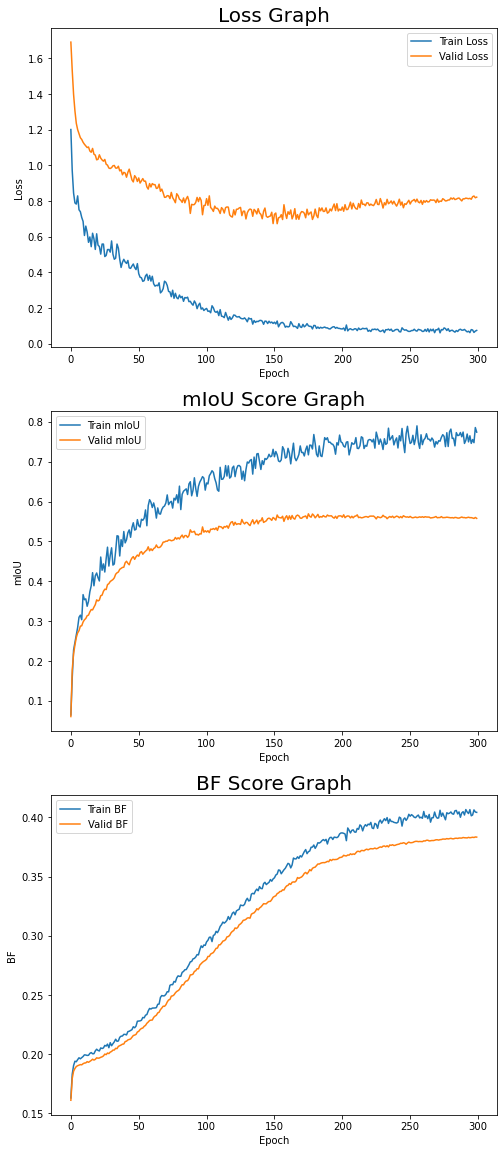

In [21]:
# check losses and miou scores graph
fig, ax = plt.subplots(3,1, figsize=(8,20))
ax[0].set_title('Loss Graph', fontsize=20)
ax[0].plot(np.arange(len(train_loss)), train_loss, label='Train Loss')
ax[0].plot(np.arange(len(valid_loss)), valid_loss, label='Valid Loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].legend(loc='best')
ax[1].set_title('mIoU Score Graph', fontsize=20)
ax[1].plot(np.arange(len(train_miou)), train_miou, label='Train mIoU')
ax[1].plot(np.arange(len(valid_miou)), valid_miou, label='Valid mIoU')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('mIoU')
ax[1].legend(loc='best')
ax[2].set_title('BF Score Graph', fontsize=20)
ax[2].plot(np.arange(len(train_bf)), train_bf, label='Train BF')
ax[2].plot(np.arange(len(valid_bf)), valid_bf, label='Valid BF')
ax[2].set_xlabel('Epoch')
ax[2].set_ylabel('BF')
ax[2].legend(loc='best')
fig.show()

In [22]:
# load test data
test_loader = DataLoader(
    CamVidDataset(transforms_, subset='test'),
    batch_size=len(test_image),
    drop_last=True,
    shuffle=False
)

In [23]:
# test
with torch.no_grad():
    for test_images, test_labels in test_loader:
        test_images = test_images.to(device)
        test_labels = test_labels.to(device)
        # predict
        test_outputs = model(test_images)
        loss = loss_func(test_outputs, test_labels)
        test_miou = metric.get_miou(test_outputs, test_labels)
        print(f'Test Loss: {loss.item():.3f},'
              f'  Test mIoU: {test_miou:.3f}')

Test Loss: 0.609,  Test mIoU: 0.513


In [24]:
# 12 classes channels to 3 RGB channels
def map_class_to_rgb(p):
    return rgb_array[p[0]]

def mask2rgb(images):
    rgb_img_list = []
    for img in tqdm(images):
        img = img.detach().cpu().numpy()
        img = np.transpose(img, (1,2,0))
        img = np.argmax(img, axis=-1)
        rgb_img = np.apply_along_axis(map_class_to_rgb, -1, np.expand_dims(img, -1))
        rgb_img_list.append(rgb_img)
    return np.array(rgb_img_list)

test_result = mask2rgb(test_outputs)

  0%|          | 0/233 [00:00<?, ?it/s]

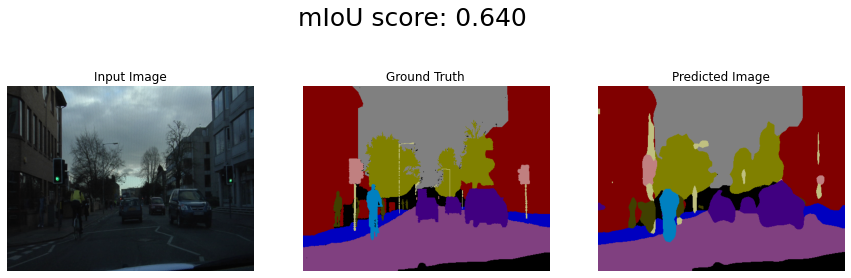

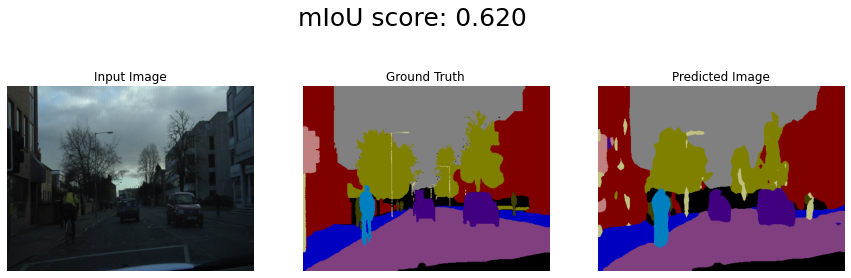

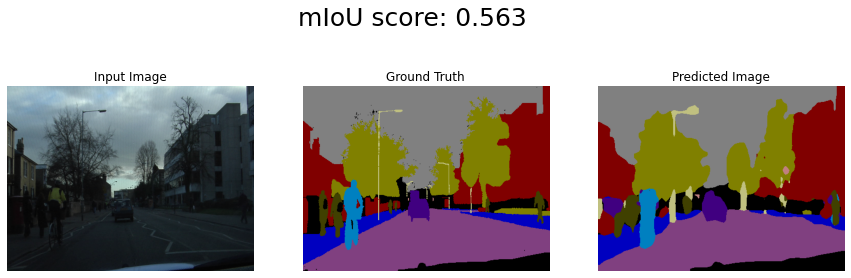

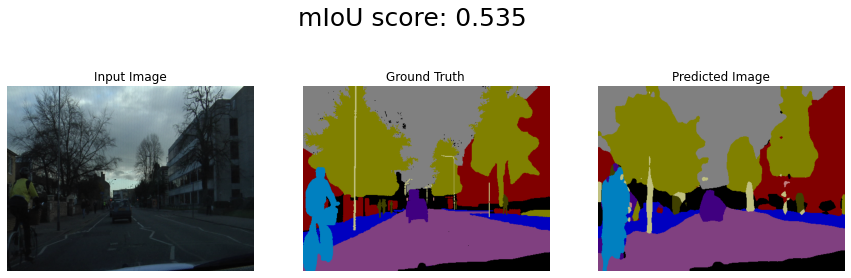

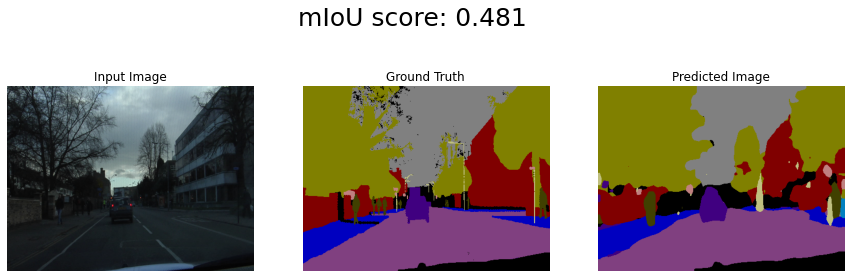

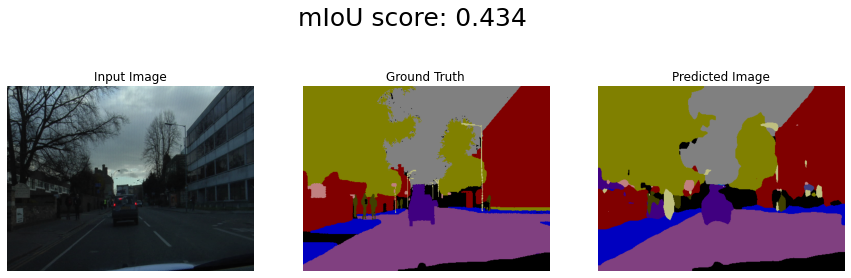

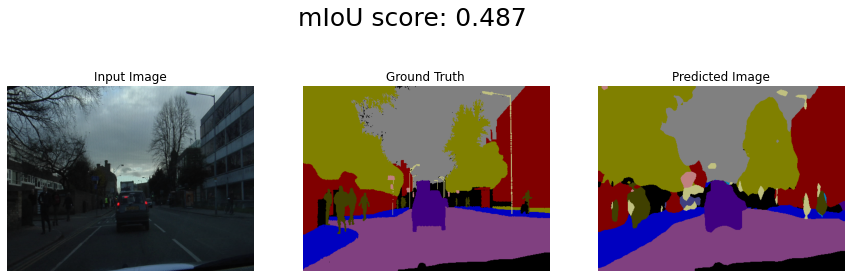

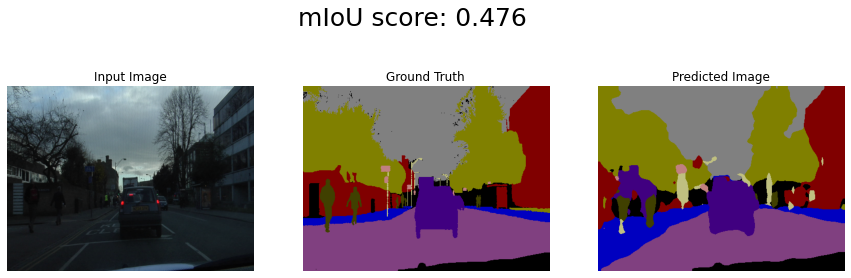

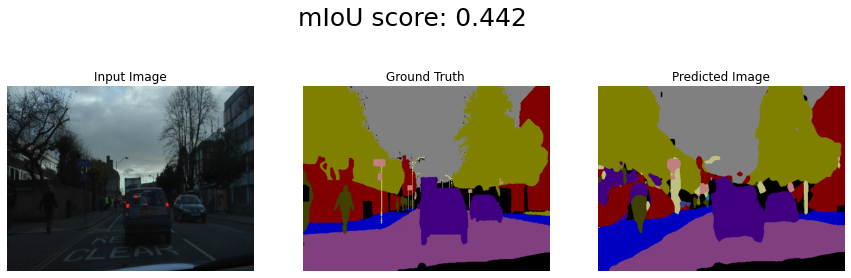

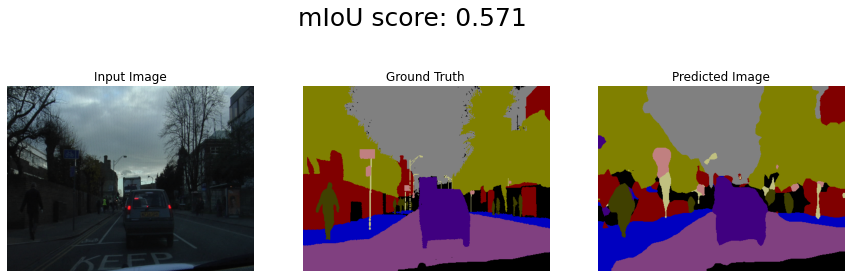

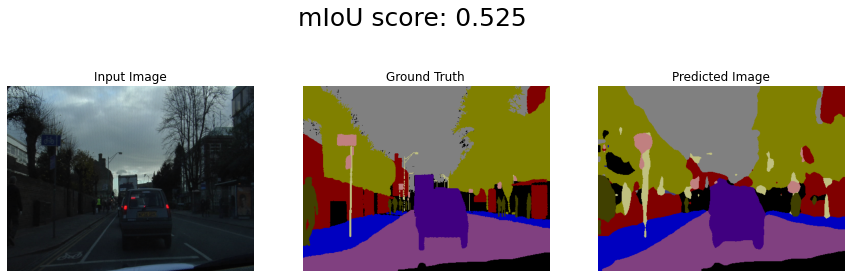

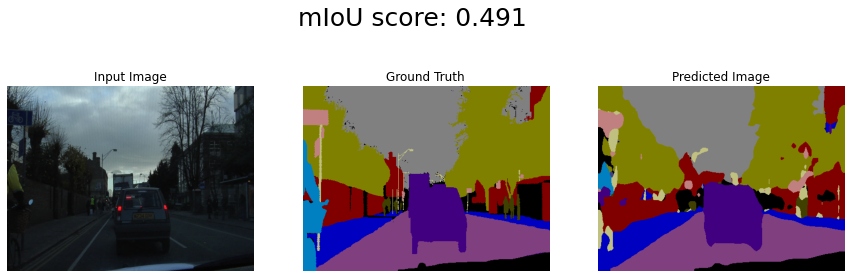

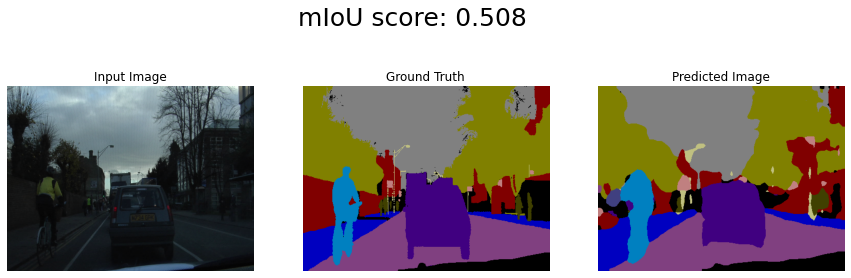

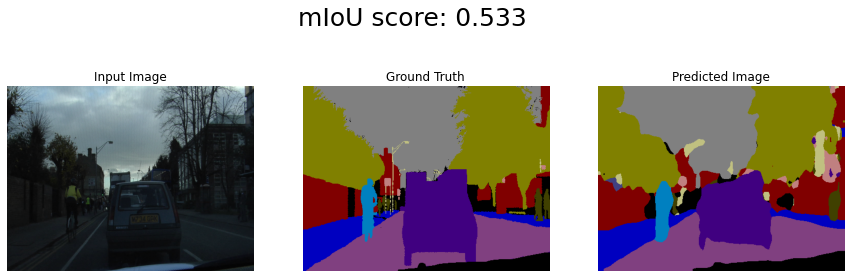

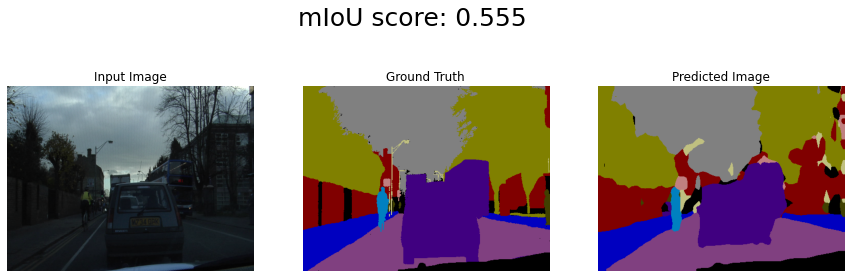

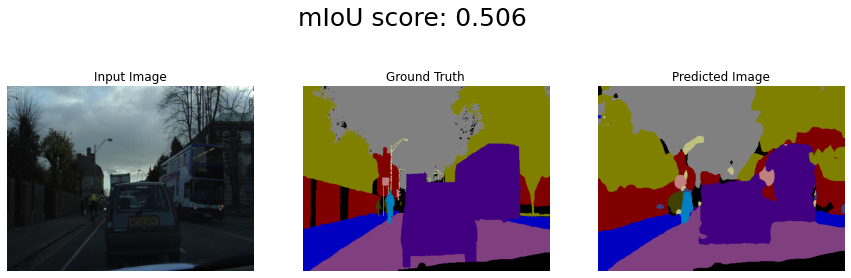

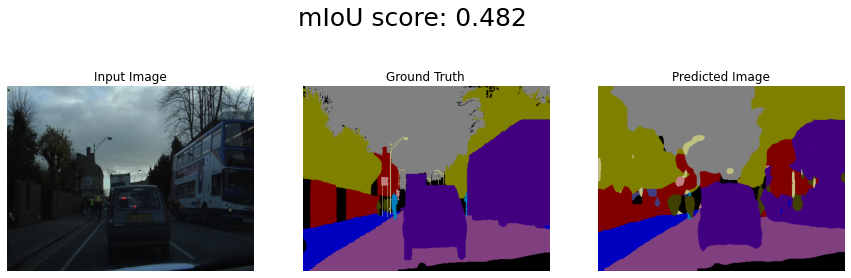

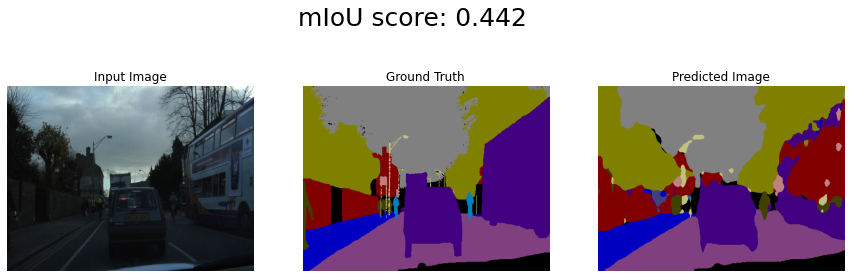

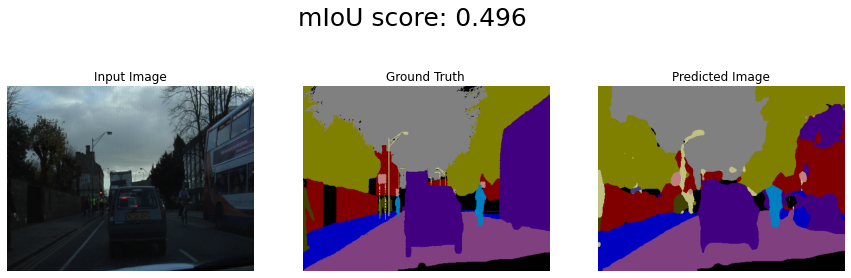

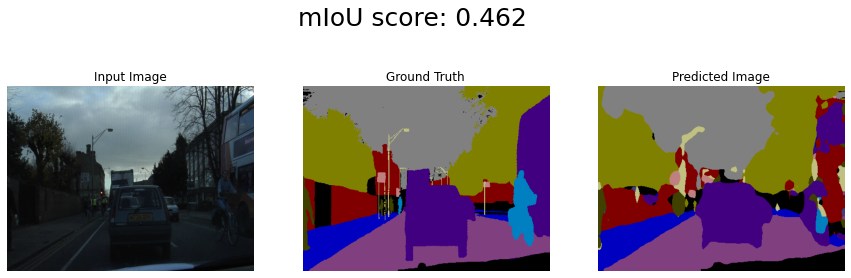

In [25]:
# show test outputs with miou score
test_metric = Metrics(n_classes=num_classes, dim=0)

def show_result(image, label, mask, model_pred, rgb_pred, ncols):
    for i in range(ncols):
        # get miou score
        miou = test_metric.get_miou(mask[i], model_pred[i])
        # plot images
        fig, ax = plt.subplots(1,3, figsize=(15,5))
        fig.suptitle(f'mIoU score: {miou:.3f}', fontsize=25)
        ax[0].imshow(image[i])
        ax[0].axis('off')
        ax[0].set_title('Input Image')
        ax[1].imshow(label[i])
        ax[1].axis('off')
        ax[1].set_title(f'Ground Truth')
        ax[2].imshow(rgb_pred[i])
        ax[2].axis('off')
        ax[2].set_title(f'Predicted Image')
        fig.show()

show_result(test_image, test_label, test_labels, test_outputs, test_result, 20)